# LangGraph: Multi-Agent Parallel Processing with Different LLMs

-  **Definition and Purpose**: Parallelization allows Large Language Models (LLMs) to handle a task simultaneously, merging their outputs to increase efficiency or improve result quality.
-  **Two Main Variations**:
      - "Sectioning" (splitting a task into independent subtasks for parallel execution)
      - "Voting" (executing the same task multiple times to obtain diverse outputs).
-  **Optimal Use Cases**:
     - Speeds up tasks through parallel subtask execution.
     - Provides higher confidence by gathering multiple perspectives, especially for complex tasks where LLMs can focus on specific aspects.

## Key Concepts

-  **Multi-Agent Architecture**: Rather than relying on a single agent, a team of specialized agents collaborates. Each agent has a unique role and is powered by a carefully chosen LLM.
-  **Parallel Execution**: These agents operate concurrently. The workflow starts at a common point, branches out to individual agents, and converges at the final node upon completion.
-  **LLM Specialization**: Different OpenAI models are matched to specific tasks:
     - `gpt-4o`: A powerful model for generating insightful and relevant questions.
     - `gpt-4o-mini`: A cost-effective, creative model ideal for crafting jokes.
     - `gpt-3.5-turbo`: A fast, balanced model for identifying related topics.
-  **State Management**: The `AgentState` TypedDict facilitates information sharing among agents. It serves as a shared memory space where each agent can access the initial topic and store its results.

## 1. Setup and Environment

In [51]:
import os
from typing import TypedDict, List
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import JsonOutputParser
from langgraph.graph import StateGraph, END
from dotenv import load_dotenv
from langchain_ollama import ChatOllama, OllamaEmbeddings
from rich import print
# Load environment variables from .env file
load_dotenv()

# Set up the OpenAI API key
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY')
os.environ['LANGCHAIN_TRACING_V2'] = 'false'  # Disable LangChain tracing for cleaner output
langchain_api_key = os.getenv('LANGCHAIN_API_KEY')
if langchain_api_key:
    os.environ['LANGCHAIN_API_KEY'] = langchain_api_key

## 2. Defining the Graph State

- `topic`: The input topic that the agents will work on.
- `questions`: A list to store the questions generated by the `question_agent`.
- `jokes`: A list to store the jokes generated by the `joke_agent`.
- `related_topics`: A list to store related topics from the `related_topics_agent`.

In [52]:
class AgentState(TypedDict):
    topic: str
    questions: List[str]
    jokes: List[str]
    related_topics: List[str]

## 3. Initializing Specialized LLMs

- Initialize three specialized LLMs for specific tasks.  
- Each model is chosen for its suitability for a specific task. This is a key aspect of the multi-agent design pattern, allowing for optimization of both performance and cost.

### LLMs Used:
- `llm_questions` (`gpt-4o`): Chosen for its strong reasoning and generation capabilities to produce high-quality, relevant questions.
- `llm_jokes` (`gpt-4o-mini`): A more creative and less expensive model, ideal for the lighthearted task of generating humor.
- `llm_related` (`gpt-3.5-turbo`): A fast and balanced model, well-suited for identifying connections and related concepts.

In [53]:
llm_questions = ChatOpenAI(model='gpt-4o', temperature=0.1)  # Most capable for thoughtful questions
llm_jokes = ChatOpenAI(model='gpt-4o-mini', temperature=0.8)  # Creative for humor
llm_related = ChatOpenAI(model='gpt-3.5-turbo', temperature=0.3)  # Balanced for topic connections

## 4. Creating Generation Chains

We create a helper function `create_generation_chain` to build the processing chains for our agents. Each chain consists of a prompt, an LLM, and a JSON output parser.

- **Prompt**: The `ChatPromptTemplate` guides the LLM on what to generate.
- **LLM**: The language model that processes the prompt.
- **Parser**: The `JsonOutputParser` ensures the output is in a structured JSON format, making it easy to integrate back into our `AgentState`.

In [54]:
def create_generation_chain(llm, prompt_template_str: str):
    """Creates a chain for generating content based on a topic."""
    prompt = ChatPromptTemplate.from_template(prompt_template_str)
    parser = JsonOutputParser()
    return prompt | llm | parser

We then use this helper function to create a specific chain for each agent, each with its own prompt and specialized LLM.

In [56]:
question_chain = create_generation_chain(
    llm_questions,
    'Generate 5 questions about the following topic: {topic}. Output as a JSON object with a single key "output" that contains a list of strings.',
)
joke_chain = create_generation_chain(
    llm_jokes,
    'Generate 3 jokes about the following topic: {topic}. Output as a JSON object with a single key "output" that contains a list of strings.',
)
related_topics_chain = create_generation_chain(
    llm_related,
    'Generate 4 related topics for the following topic: {topic}. Output as a JSON object with a single key "output" that contains a list of strings.',
)

## 5. Defining the Agent Nodes

Each agent is defined as a node in the graph. These functions take the current state as input, invoke their respective generation chains, and return the results to be merged back into the state.

- `question_agent`: Generates questions using `gpt-4o`.
- `joke_agent`: Generates jokes using `gpt-4o-mini`.
- `related_topics_agent`: Generates related topics using `gpt-3.5-turbo`.

Each agent includes error handling to gracefully manage any issues during generation.

In [57]:
def question_agent(state: AgentState):
    """Generates questions based on the topic using GPT-4o."""
    print('---GENERATING QUESTIONS (GPT-4o)---')
    result = question_chain.invoke({'topic': state['topic']})
    return {'questions': result['output']}


def joke_agent(state: AgentState):
    """Generates jokes based on the topic using GPT-4o-mini."""
    print('---GENERATING JOKES (GPT-4o-mini)---')
    
    result = joke_chain.invoke({'topic': state['topic']})
    return {'jokes': result['output']}

def related_topics_agent(state: AgentState):
    """Generates related topics based on the topic using GPT-3.5-turbo."""
    print('---GENERATING RELATED TOPICS (GPT-3.5-turbo)---')
    result = related_topics_chain.invoke({'topic': state['topic']})
    return {'related_topics': result['output']}

## 6. Building and Compiling the Graph

Now we assemble the graph using `StateGraph`.

1.  **Add Nodes**: We add each agent function as a node in the graph.
2.  **Set Entry Point**: A key feature for parallel execution is setting multiple entry points. By calling `set_entry_point` for each agent, we instruct LangGraph to run them all concurrently as soon as the graph is invoked.
3.  **Add Edges**: We define the graph's flow. Since all agents run in parallel and the process finishes after they are done, we add an edge from each agent node directly to `END`.
4.  **Compile**: Finally, we compile the workflow into a runnable application.

In [58]:
workflow = StateGraph(AgentState)

# Add nodes for each agent
workflow.add_node('question_agent', question_agent)
workflow.add_node('joke_agent', joke_agent)
workflow.add_node('related_topics_agent', related_topics_agent)

# The entry point is the topic, which then triggers the parallel agents
workflow.set_entry_point('question_agent')
workflow.set_entry_point('joke_agent')
workflow.set_entry_point('related_topics_agent')

# All parallel agents lead to the end
workflow.add_edge('question_agent', END)
workflow.add_edge('joke_agent', END)
workflow.add_edge('related_topics_agent', END)

# Compile the graph
app = workflow.compile()

### Visualizing the Graph

Here is a visual representation of our parallel agent graph. As you can see, the graph starts and immediately branches out to the three agents, which run in parallel before reaching the end.

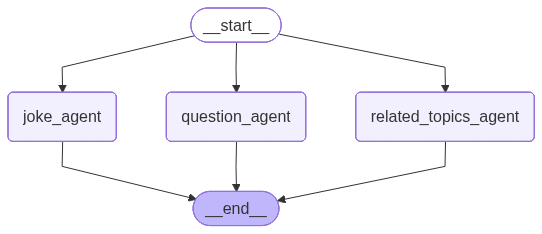

In [59]:
from IPython.display import Image, display

try:
    # Generate the Mermaid diagram and save it as a PNG
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Error generating graph visualization: {e}")

## 7. Running the Graph

With the graph compiled, we can now run it. We'll test it with a few different topics to see how the agents perform.

For each topic:
1.  We define an `initial_state` dictionary containing the topic.
2.  We `invoke` the compiled app with this state.
3.  The graph executes the three agents in parallel.
4.  The final state, containing the results from all agents, is returned and printed.

In [ ]:
from rich import print
print('🚀 LangGraph Multi-Agent Parallel Processing with Different LLMs')
print('=' * 65)
print('🤖 Question Agent: GPT-4o (Most capable for thoughtful questions)')
print('😂 Joke Agent: GPT-4o-mini (Creative and cost-effective for humor)')
print('🔗 Related Topics Agent: GPT-3.5-turbo (Balanced for connections)')
print('=' * 65)

# Test with multiple topics
# test_topics = ['Artificial Intelligence', 'Space Exploration', 'Your Mom']
test_topics = ['Artificial Intelligence']

for topic in test_topics:
    print(f'\n🎯 Processing Topic: {topic}')
    print('⚡ Running parallel agents with different LLMs...')

    initial_state = {'topic': topic, 'questions': [], 'jokes': [], 'related_topics': []}

    final_state = app.invoke(initial_state)

    print(f'\n📊 RESULTS FOR: {final_state["topic"].upper()}')
    print('-' * 50)

    print(f'\n🤔 QUESTIONS (Generated by GPT-4o):')
    for i, q in enumerate(final_state['questions'], 1):
        print(f'  {i}. {q}')

    print(f'\n😂 JOKES (Generated by GPT-4o-mini):')
    for i, j in enumerate(final_state['jokes'], 1):
        print(f'  {i}. {j}')

    print(f'\n🔗 RELATED TOPICS (Generated by GPT-3.5-turbo):')
    for i, t in enumerate(final_state['related_topics'], 1):
        print(f'  {i}. {t}')
    # print results separator in red 
    
    print('\n' + '=' * 65)

print('\n✅ Demo completed! Each agent used a different LLM model.')

🚀 LangGraph Multi-Agent Parallel Processing with Different LLMs

=================================================================

🤖 Question Agent: GPT-4o (Most capable for thoughtful questions)

😂 Joke Agent: GPT-4o-mini (Creative and cost-effective for humor)

🔗 Related Topics Agent: GPT-3.5-turbo (Balanced for connections)

=================================================================

🎯 Processing Topic: Artificial Intelligence

⚡ Running parallel agents with different LLMs...

---GENERATING JOKES (GPT-4o-mini)---

---GENERATING QUESTIONS (GPT-4o)---

---GENERATING RELATED TOPICS (GPT-3.5-turbo)---

📊 RESULTS FOR: ARTIFICIAL INTELLIGENCE

--------------------------------------------------

🤔 QUESTIONS (Generated by GPT-4o):

1. What are the ethical implications of using artificial intelligence in decision-making processes?

2. How does machine learning differ from traditional programming in the context of artificial intelligence?

3. What are the potential benefits and risks of implementing artificial intelligence in healthcare?

4. How can artificial intelligence be used to improve efficiency and productivity in various industries?

5. What are the current limitations of artificial intelligence technology, and how might they be addressed in the
future?

😂 JOKES (Generated by GPT-4o-mini):

1. Why did the robot go on a diet? Because it had too many bytes!

2. Why did the AI break up with its partner? It just couldn't find the right algorithm for love!

3. How do AI systems like to organize a party? They use a neural network to get everyone connected!

🔗 RELATED TOPICS (Generated by GPT-3.5-turbo):

1. Machine Learning

2. Neural Networks

3. Natural Language Processing

4. Robotics

=================================================================

✅ Demo completed! Each agent used a different LLM model.

In [62]:
from rich import print
from rich.rule import Rule

print("[bold cyan]🚀 LangGraph Multi-Agent Parallel Processing with Different LLMs[/]")
print(Rule(style="cyan"))
print("[bold yellow]🤖 Question Agent:[/] [white]GPT-4o[/] [dim](Most capable for thoughtful questions)[/]")
print("[bold magenta]😂 Joke Agent:[/] [white]GPT-4o-mini[/] [dim](Creative & cost-effective for humor)[/]")
print("[bold green]🔗 Related Topics Agent:[/] [white]GPT-3.5-turbo[/] [dim](Balanced for connections)[/]")
print(Rule(style="cyan"))

# Test with multiple topics (single topic for quick demo)
test_topics = ['Artificial Intelligence', 'Climate Change', 'Space Exploration']
# test_topics = ['Artificial Intelligence']

for topic in test_topics:
    print(f"\n[bold underline bright_white]🎯 Processing Topic:[/] [bold green]{topic}[/]")
    print("[bold cyan]⚡ Running parallel agents with different LLMs...[/]")

    initial_state = {'topic': topic, 'questions': [], 'jokes': [], 'related_topics': []}
    final_state = app.invoke(initial_state)

    print(f"\n[bold white on blue] 📊 RESULTS FOR: {final_state['topic'].upper()} [/]")
    print(Rule(style="blue"))

    # QUESTIONS
    print("[bold yellow]🤔 QUESTIONS (GPT-4o):[/]")
    if final_state['questions']:
        for i, q in enumerate(final_state['questions'], 1):
            print(f"  [yellow]{i}.[/] {q}")
    else:
        print("  [red]No questions generated.[/]")

    # JOKES
    print("\n[bold magenta]😂 JOKES (GPT-4o-mini):[/]")
    if final_state['jokes']:
        for i, j in enumerate(final_state['jokes'], 1):
            print(f"  [magenta]{i}.[/] {j}")
    else:
        print("  [red]No jokes generated.[/]")

    # RELATED TOPICS
    print("\n[bold green]🔗 RELATED TOPICS (GPT-3.5-turbo):[/]")
    if final_state['related_topics']:
        for i, t in enumerate(final_state['related_topics'], 1):
            print(f"  [green]{i}.[/] {t}")
    else:
        print("  [red]No related topics generated.[/]")

    print(Rule(style="red"))

print("\n[bold green]✅ Demo completed! Each agent used a different LLM model.[/]")

🚀 LangGraph Multi-Agent Parallel Processing with Different LLMs

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

🤖 Question Agent: GPT-4o (Most capable for thoughtful questions)

😂 Joke Agent: GPT-4o-mini (Creative & cost-effective for humor)

🔗 Related Topics Agent: GPT-3.5-turbo (Balanced for connections)

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

🎯 Processing Topic: Artificial Intelligence

⚡ Running parallel agents with different LLMs...

---GENERATING JOKES (GPT-4o-mini)---

---GENERATING QUESTIONS (GPT-4o)---

---GENERATING RELATED TOPICS (GPT-3.5-turbo)---

 📊 RESULTS FOR: ARTIFICIAL INTELLIGENCE 

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

🤔 QUESTIONS (GPT-4o):

1. What are the ethical considerations surrounding the use of artificial intelligence in decision-making 
processes?

2. How does machine learning differ from traditional programming in the context of artificial intelligence?

3. What are the potential impacts of artificial intelligence on the job market and employment opportunities?

4. How can artificial intelligence be used to improve healthcare outcomes and patient care?

5. What are the challenges in ensuring the security and privacy of data used in artificial intelligence systems?

😂 JOKES (GPT-4o-mini):

1. Why did the robot go on a diet? Because he had too many bytes!

2. Why did the AI break up with its partner? It just couldn't find the right algorithm for love!

3. How do you throw a party for artificial intelligence? You just need to invite a few good circuits!

🔗 RELATED TOPICS (GPT-3.5-turbo):

1. Machine learning

2. Neural networks

3. Natural language processing

4. Robotics

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

🎯 Processing Topic: Climate Change

⚡ Running parallel agents with different LLMs...

---GENERATING JOKES (GPT-4o-mini)---

---GENERATING QUESTIONS (GPT-4o)---

---GENERATING RELATED TOPICS (GPT-3.5-turbo)---

 📊 RESULTS FOR: CLIMATE CHANGE 

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

🤔 QUESTIONS (GPT-4o):

1. What are the primary causes of climate change and how do they impact the environment?

2. How does climate change affect global weather patterns and what are the potential consequences?

3. What are some effective strategies for mitigating the effects of climate change on a global scale?

4. How do rising temperatures and changing precipitation patterns influence biodiversity and ecosystems?

5. What role do renewable energy sources play in combating climate change and reducing carbon emissions?

😂 JOKES (GPT-4o-mini):

1. Why did the climate scientist break up with their partner? They needed space to cool down!

2. What did the ocean say to the beach during a climate change debate? 'I can't handle the rising tide of your 
excuses!'

3. Why are climate change activists great musicians? Because they know how to drop the bass and raise the 
temperatures!

🔗 RELATED TOPICS (GPT-3.5-turbo):

1. Global warming

2. Greenhouse gases

3. Renewable energy

4. Deforestation

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

🎯 Processing Topic: Space Exploration

⚡ Running parallel agents with different LLMs...

---GENERATING JOKES (GPT-4o-mini)---

---GENERATING QUESTIONS (GPT-4o)---

---GENERATING RELATED TOPICS (GPT-3.5-turbo)---

 📊 RESULTS FOR: SPACE EXPLORATION 

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

🤔 QUESTIONS (GPT-4o):

1. What are the primary objectives of current space exploration missions?

2. How has international collaboration impacted the progress of space exploration?

3. What technological advancements have been made as a result of space exploration?

4. What are the challenges and risks associated with long-duration space missions?

5. How does space exploration contribute to our understanding of the universe?

😂 JOKES (GPT-4o-mini):

1. Why did the astronaut break up with his girlfriend? Because he needed space!

2. How do astronauts keep their pants up in space? With asteroid belts!

3. What did one alien say to the other when they saw Earth? 'I think we should invade; it looks like they need 
some help with their gravity!'

🔗 RELATED TOPICS (GPT-3.5-turbo):

1. Manned missions to Mars

2. Commercial space travel

3. Exploration of exoplanets

4. Space tourism

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

✅ Demo completed! Each agent used a different LLM model.